## Final Project Submission

* Student name: Group 5
* Members: Francis Ndirangu, Hanifa Chepchirchir, Brian Kipyegon, Ian Riua, Denis Kibor
* Student pace: full time
* Scheduled project review date/time: 2/5/2025
* Instructor name: Nikita Njoroge.
* Blog post URL: 

## Introduction

Our company wants to venture into the movie industry by launching a new movie studio. However, as a newcomer in this competitive space, we currently lack the insights and experience to determine what types of films will yield the greatest commercial success.

This project aims to bridge that gap.

By analyzing recent data from sources such as IMDb, The Movies and The Numbers, we will explore trends in genre, director success, language profitability, movie_popularity, and budget efficiency over the past years. Our goal is to identify which types of films — by genre, language, or production strategy — consistently perform well at the box office.

The findings from this analysis will be translated into actionable recommendations that the company can use to make data-driven decisions on what types of films to create, how to allocate production budgets, and who to collaborate with in the filmmaking process.

## Step 1: Importing the necessary Libraries.

To perform this analysis, we use a combination of powerful Python libraries.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from statsmodels.stats.weightstats import ttest_ind

## Step 2: Loading Datasets and Merging

In this step we will load the datasets and extract information that we will use for our analysis.

### 1. IMDB Database 
We will first look at the IMDb database. Because it's an database we will use sql to connect to it and the combine pandas and sql to create dataframes from the database.

In [3]:
# Connect sqlite3 to the database and fetch all tables
con = sqlite3.connect(r'zippedData\im.db\im.db')

cur = con.cursor()

cur.execute("SELECT name from sqlite_master").fetchall()

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

## Combining Tables from Imdb

To create a single dataset with rich movie-level insights, we will join multiple tables from our IMDb database. This includes information about movies, their alternate titles, ratings, key personnel (like actors and directors), and their roles.

By joining `principals`, `movie_akas`, `movie_basics`, `movie_ratings`, and `persons` using shared IDs (`movie_id` and `person_id`), we will build a comprehensive dataframe that allows us to analyze movies from multiple perspectives.


In [4]:
# Run a comprehensive SQL join to combine key movie-related tables:
# This unified query brings together movie titles, alternate names, ratings, and contributor details.

combined = """SELECT *
                from principals
                JOIN movie_akas USING (movie_id)
                JOIN movie_basics USING (movie_id)
                JOIN movie_ratings USING (movie_id)
                JOIN persons USING (person_id);"""

combined_df = pd.read_sql_query(combined,con)
combined_df.head()

,movie_id,ordering,person_id,category,job,characters,ordering,title,region,language,...,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,primary_name,birth_year,death_year,primary_profession
0,tt0323808,10,nm0059247,editor,None,None,1,May Day,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
1,tt0323808,10,nm0059247,editor,None,None,2,Cowboys for Christ,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
2,tt0323808,10,nm0059247,editor,None,None,3,The Wicker Tree,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
3,tt0323808,10,nm0059247,editor,None,None,4,The Wicker Tree,None,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
4,tt0323808,10,nm0059247,editor,None,None,5,Плетеное дерево,RU,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"


In [5]:
# Create a copy of the combined dataframe to preserve the original and inspect its structure

imdb_df = combined_df.copy()
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422866 entries, 0 to 2422865
Data columns (total 24 columns):
 #   Column              Dtype  
---  ------              -----  
 0   movie_id            object 
 1   ordering            int64  
 2   person_id           object 
 3   category            object 
 4   job                 object 
 5   characters          object 
 6   ordering            int64  
 7   title               object 
 8   region              object 
 9   language            object 
 10  types               object 
 11  attributes          object 
 12  is_original_title   float64
 13  primary_title       object 
 14  original_title      object 
 15  start_year          int64  
 16  runtime_minutes     float64
 17  genres              object 
 18  averagerating       float64
 19  numvotes            int64  
 20  primary_name        object 
 21  birth_year          float64
 22  death_year          float64
 23  primary_profession  object 
dtypes: float64(5), int64(4),

#### Checking for missing values

In the cell below we check the null value percentage for each column in the dataframe.

We will rank the null value percentage in descending order.

We want to remove the null values from the dataframe before we combine it with the other dataframes

In [6]:
#checking columns with null values.
imdb_df.isna().mean()[imdb_df.isna().mean() > 0].sort_values(ascending=False)

death_year            0.982493
attributes            0.949760
language              0.855840
job                   0.725228
characters            0.606105
birth_year            0.564602
types                 0.402041
region                0.162510
runtime_minutes       0.039211
primary_profession    0.021650
genres                0.003738
dtype: float64

### Steps to be taken regarding null values:

1. The columns with more than 60% null values will be dropped.

2. The null value rows of the remaining columns will be dropped.



In [7]:
#dropping the columns with 40%+ null values
imdb_df.drop(labels=['death_year','attributes','language','job','characters','birth_year','types'],axis=1,inplace=True)

#checking columns with null values.
imdb_df.isna().mean()[imdb_df.isna().mean() > 0].sort_values(ascending=False)

region                0.162510
runtime_minutes       0.039211
primary_profession    0.021650
genres                0.003738
dtype: float64

Now that we have confirmed the dropping of columns with more than 60% null values.

We will now drop the null value rows of the remaining columns.

In [44]:
columns_with_null_values = imdb_df.isna().mean()[imdb_df.isna().mean() > 0].index.tolist()
columns_with_null_values

#I will drop all the rows with null values since they are only a small percentage of the dataset.
imdb_df.dropna(axis=0,subset=columns_with_null_values,inplace=True)
#checking columns with null values.
imdb_df.isna().mean()[imdb_df.isna().mean() > 0].sort_values(ascending=False)

#The output of the empty list is showing that there are no missing values in the dataset.

Series([], dtype: float64)

In [9]:
# checking the info of the dataframe
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909588 entries, 0 to 2422865
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   movie_id            object 
 1   ordering            int64  
 2   person_id           object 
 3   category            object 
 4   ordering            int64  
 5   title               object 
 6   region              object 
 7   is_original_title   float64
 8   primary_title       object 
 9   original_title      object 
 10  start_year          int64  
 11  runtime_minutes     float64
 12  genres              object 
 13  averagerating       float64
 14  numvotes            int64  
 15  primary_name        object 
 16  primary_profession  object 
dtypes: float64(3), int64(4), object(10)
memory usage: 262.2+ MB


## 2. TMDb Movies Dataset

We will now load the TMDb (The Movie Database) dataset, which provides additional movie-related information such as popularity scores, average ratings, and original language. This data will help us explore audience preferences and language trends, and enrich our overall analysis of movie performance.


In [10]:
tmdb_movies_df = pd.read_csv(r'zippedData\tmdb.movies.csv\tmdb.movies.csv')
tmdb_movies_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


## 3. The Numbers Dataset

To analyze the financial performance of movies, we load a dataset containing production budgets, domestic and international grosses, and release dates. This data comes from <b>The Numbers</b> and is essential for calculating net profits and evaluating the commercial success of films.

In [11]:
movie_budgets_df = pd.read_csv(r'zippedData\tn.movie_budgets.csv\tn.movie_budgets.csv') #,on_bad_lines='skip'

movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"



At this stage, we have successfully loaded all the required datasets from IMDb, TMDb and The Numbers. Through careful inspection of each dataset’s structure, we now have  comprehensive datasets without missing values and duplicates.



## Merging IMDb and TMDb Datasets

After looking at the datasets that we have chosen for ou analysis, we noticed that imdb and tmdb datasets contains information about movies that's almost similar(they complement each other)

We decided merge the 2 datasets using the `title` column as the key. This will allow us to combine detailed movie information from IMDb (like genres, ratings, and contributors) with TMDB

In [12]:
imdb_tmdb = pd.merge(imdb_df,tmdb_movies_df,on='title')
imdb_tmdb.head()

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,primary_profession,Unnamed: 0,genre_ids,id,original_language,original_title_y,popularity,release_date,vote_average,vote_count
0,tt0323808,10,nm0059247,editor,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,"editor,editorial_department,assistant_director",5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25
1,tt0323808,1,nm3579312,actress,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,"actress,soundtrack",5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25
2,tt0323808,2,nm2694680,actor,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,actor,5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25
3,tt0323808,3,nm0574615,actor,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,"actor,soundtrack,director",5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25
4,tt0323808,4,nm0502652,actress,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,actress,5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25


In [13]:
# checking the info of the dataframe
imdb_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289507 entries, 0 to 289506
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            289507 non-null  object 
 1   ordering            289507 non-null  int64  
 2   person_id           289507 non-null  object 
 3   category            289507 non-null  object 
 4   ordering            289507 non-null  int64  
 5   title               289507 non-null  object 
 6   region              289507 non-null  object 
 7   is_original_title   289507 non-null  float64
 8   primary_title       289507 non-null  object 
 9   original_title_x    289507 non-null  object 
 10  start_year          289507 non-null  int64  
 11  runtime_minutes     289507 non-null  float64
 12  genres              289507 non-null  object 
 13  averagerating       289507 non-null  float64
 14  numvotes            289507 non-null  int64  
 15  primary_name        289507 non-nul


## Adding Budget and Revenue Data

In this step, we will merge our combined IMDb-TMDb dataset with financial data from <b>The Numbers</b> dataset. We’ll match records using the movie `title` from IMDb-TMDb and the `movie` column from the budgets dataset. This merge will give us access to key financial figures like production budgets, domestic gross, and worldwide gross — essential for analyzing box office performance.


In [14]:
# merge imdb_tmdb_merge to numbers

all_merge = pd.merge(imdb_tmdb,movie_budgets_df,left_on='title',right_on='movie')
all_merge.head()

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,movie,production_budget,domestic_gross,worldwide_gross
0,tt0475290,10,nm0005683,cinematographer,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
1,tt0475290,1,nm0000982,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
2,tt0475290,2,nm0000123,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
3,tt0475290,3,nm2403277,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
4,tt0475290,4,nm0000146,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"


In [15]:
# checking the info of the dataframe
all_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84687 entries, 0 to 84686
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            84687 non-null  object 
 1   ordering            84687 non-null  int64  
 2   person_id           84687 non-null  object 
 3   category            84687 non-null  object 
 4   ordering            84687 non-null  int64  
 5   title               84687 non-null  object 
 6   region              84687 non-null  object 
 7   is_original_title   84687 non-null  float64
 8   primary_title       84687 non-null  object 
 9   original_title_x    84687 non-null  object 
 10  start_year          84687 non-null  int64  
 11  runtime_minutes     84687 non-null  float64
 12  genres              84687 non-null  object 
 13  averagerating       84687 non-null  float64
 14  numvotes            84687 non-null  int64  
 15  primary_name        84687 non-null  object 
 16  prim

In [46]:
#Confirming there are no columns with null values in the merged dataset.
all_merge.isna().any()[all_merge.isna().any() == True]

#The returned empty list shows that there are no columns with  null values.

Series([], dtype: bool)

## Conclusion.

At this stage, we have successfully loaded all the required datasets from IMDb, TMDb, Box Office Mojo, and The Numbers. Through careful merging and inspection of each dataset’s structure, we now have a comprehensive dataset that combines:

- **Movie details** (titles, genres, release years)
- **Ratings and popularity metrics**
- **Contributor information** (directors, actors, and other key personnel)
- **Financial data** (production budgets, domestic and worldwide gross)

This unified dataset will serve as the foundation for our analysis, allowing us to explore trends in genres, profitability, and key performance drivers across the film industry. 


## Step 2: Data Cleaning

Before performing any analysis, it's important to clean the dataset to ensure accuracy and consistency. This step will involve:

- Removing or handling missing values (e.g., missing genres or financial figures)
- Fixing duplicates or inconsistent entries
- Standardizing column formats (e.g., dates, currencies)
- Creating new calculated fields such as profits

A clean and well-structured dataset will allow us to generate reliable insights in the next steps of the project.


In [16]:
# Checking for duplicates in our merged data

all_merge[all_merge.duplicated() == True]

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,movie,production_budget,domestic_gross,worldwide_gross


Our data doesn't have any duplicated values, so we will move to the next step.

In [ ]:
# checking if there's any column with missing values
all_merge.isna().any()[all_merge.isna().any() == True]

Series([], dtype: bool)

The data does not also have missing values. So we move on

In [19]:
# rename our datframe to all_combined
all_combined = all_merge

In [20]:
# checking for the columns of our combined dataframe
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'Unnamed: 0', 'genre_ids', 'id_x',
       'original_language', 'original_title_y', 'popularity', 'release_date_x',
       'vote_average', 'vote_count', 'id_y', 'release_date_y', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross'],
      dtype='object')

### Cleaning Currency Columns

The financial columns in our dataset (`production_budget`, `domestic_gross`, and `worldwide_gross`) are stored as strings with dollar signs and commas, which prevents numerical analysis.

In this step, we remove the dollar signs (`$`) and commas (`,`) using regular expressions, and then convert the cleaned strings into numeric (`float`) format. This transformation will allow us to perform mathematical operations such as calculating profits.


In [21]:
# Clean currency columns by removing dollar signs and commas,
# then convert them from string to float for numerical analysis

all_combined['worldwide_gross'] = all_combined['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
all_combined['domestic_gross'] = all_combined['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
all_combined['production_budget'] = all_combined['production_budget'].replace('[\$,]', '', regex=True).astype(float)


We can now create a profits column in our dataset in the step below

In [22]:
#creating a profit column worldwide_gross - production_budget
all_combined['profits'] = all_combined['worldwide_gross'] - all_combined['production_budget']
all_combined[['profits','worldwide_gross','production_budget']].head()

,profits,worldwide_gross,production_budget
0,42160680.0,64160680.0,22000000.0
1,42160680.0,64160680.0,22000000.0
2,42160680.0,64160680.0,22000000.0
3,42160680.0,64160680.0,22000000.0
4,42160680.0,64160680.0,22000000.0


<h3>Step 4. Exploratory Data anlysis<h3>

A graph of Average profits against top 20 genre combinations.

We are able to make this graph because majority of the movies in the dataset has more than one genre.

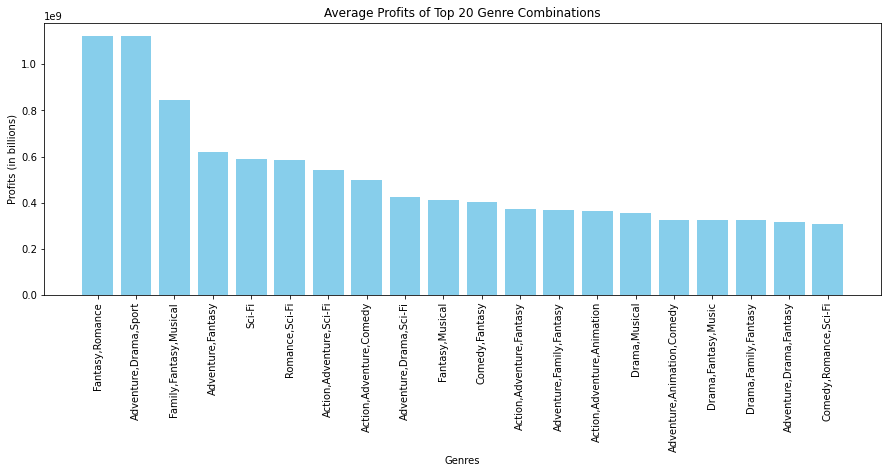

In [ ]:
# Convert the columns to strings
all_combined['worldwide_gross'] = all_combined['worldwide_gross'].astype(str).str.replace(r'\$', '', regex=True).str.replace(',', '', regex=True)
all_combined['production_budget'] = all_combined['production_budget'].astype(str).str.replace(r'\$', '', regex=True).str.replace(',', '', regex=True)

# Convert to float after cleaning
all_combined['worldwide_gross'] = pd.to_numeric(all_combined['worldwide_gross'], errors='coerce')
all_combined['production_budget'] = pd.to_numeric(all_combined['production_budget'], errors='coerce')



# Calculate profits
all_combined['profits'] = all_combined['worldwide_gross'] - all_combined['production_budget']

# Plot graph of top 20 genre combinations against profits

result = all_combined.groupby('genres')['profits'].mean().sort_values(ascending=False).head(20)
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(result.index, result.values, color='skyblue')
plt.title('Average Profits of Top 20 Genre Combinations')
plt.xlabel('Genres')
plt.ylabel('Profits (in billions)')
plt.xticks(rotation=90)
plt.show()

### We now want to graph Top 20 Individual genres against profits

As previously mentioned majority of the movies in the dataset have more than one genre. We will use the `explode` method in order to seperate the genres of each movie. Meaning that each movie will have an record for each genre in its genre combination. This will allow us to look at each individual genre and rank them.

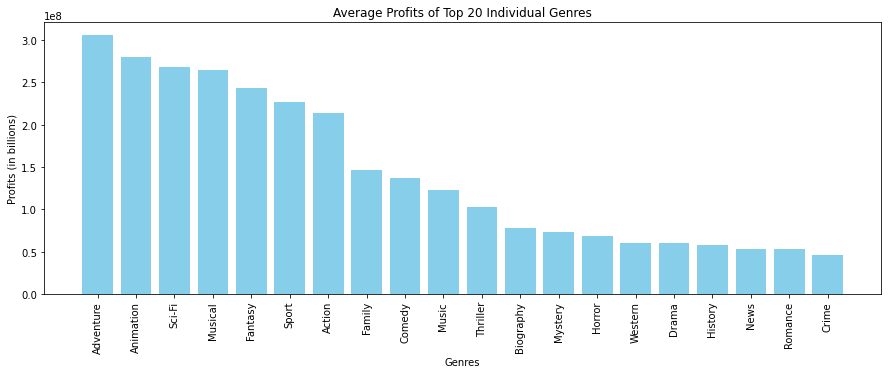

In [ ]:
all_combined.columns = [f"{col}_{i}" if all_combined.columns.tolist().count(col) > 1 else col
                        for i, col in enumerate(all_combined.columns)]

# Seperate genre combinations into individual genres using the explode method
all_combined_exploded = all_combined.assign(genres=all_combined['genres'].str.split(',')).explode('genres')

#calculating the profits of each genre
result = all_combined_exploded.groupby('genres')['profits'].mean().sort_values(ascending=False).head(20)

# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(result.index, result.values, color='skyblue')
plt.title('Average Profits of Top 20 Individual Genres')
plt.xlabel('Genres')
plt.ylabel('Profits (in billions)')
plt.xticks(rotation=90)
plt.show()

### Insight from the graph above:

We can see that Adventure, Animation and Sci-fi have the highest average profits. It is advisable for out movie studio to focus on these genres as they are likely to make the highest profits.

In the cell below we are seeing how many times each individual genre appears in the dataset

In [ ]:
#looking at the count of individual genres in the dataset ordering them by descending order
all_combined_exploded['genres'].value_counts()

Drama          45209
Action         26953
Comedy         21396
Adventure      20720
Thriller       17569
Crime          12050
Sci-Fi         10643
Horror         10605
Romance         8636
Biography       7732
Mystery         7204
Animation       5547
Fantasy         5503
Family          3682
Music           2665
History         2619
Documentary     1978
Sport           1368
War              840
Musical          434
Western          338
News              43
Name: genres, dtype: int64

### We now want to make a graph of Language against average profits.

In order to make the x-axis easier to understand we will be adding the full name of each language.

We will then graph the language vs the average profits to see which languages make the most average profit.

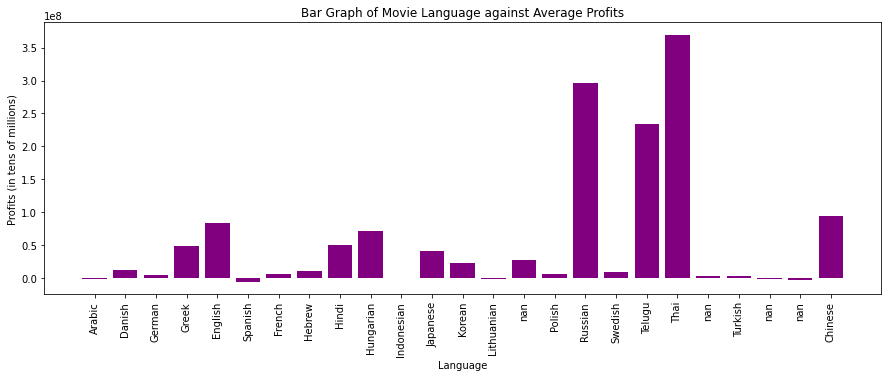

In [ ]:
language_mapping = {'en': 'English', 'es': 'Spanish', 'fr': 'French', 'de': 'German', 'it': 'Italian', 
                    'pt': 'Portuguese', 'ru': 'Russian', 'zh': 'Chinese', 'ja': 'Japanese', 'ko': 'Korean', 
                    'ar': 'Arabic', 'hi': 'Hindi', 'bn': 'Bengali', 'pa': 'Punjabi', 'id': 'Indonesian', 
                    'vi': 'Vietnamese', 'tr': 'Turkish', 'th': 'Thai', 'ms': 'Malay', 'ml': 'Malayalam', 
                    'ta': 'Tamil', 'kn': 'Kannada', 'gu': 'Gujarati', 'te': 'Telugu', 'mr': 'Marathi', 
                    'pl': 'Polish', 'uk': 'Ukrainian', 'sv': 'Swedish', 'no': 'Norwegian', 'da': 'Danish', 
                    'fi': 'Finnish', 'cs': 'Czech', 'hu': 'Hungarian', 'ro': 'Romanian', 'sk': 'Slovak', 
                    'el': 'Greek', 'he': 'Hebrew', 'th': 'Thai', 'tr': 'Turkish', 'sr': 'Serbian', 
                    'hr': 'Croatian', 'bs': 'Bosnian', 'sl': 'Slovenian', 'sq': 'Albanian', 'mk': 'Macedonian', 
                    'bg': 'Bulgarian', 'is': 'Icelandic', 'lv': 'Latvian', 'lt': 'Lithuanian', 'et': 'Estonian', 
                    'eu': 'Basque', 'gl': 'Galician', 'ca': 'Catalan', 'az': 'Azerbaijani', 'hy': 'Armenian', 
                    'ky': 'Kyrgyz', 'uz': 'Uzbek', 'km': 'Khmer', 'lo': 'Lao', 'my': 'Burmese', 'ne': 'Nepali', 
                    'si': 'Sinhalese', 'sw': 'Swahili', 'zu': 'Zulu', 'af': 'Afrikaans', 'xh': 'Xhosa', 
                    'sq': 'Albanian', 'km': 'Khmer'}

#making a df with unique movies because the all_combined has more than one actor per movie making the movies appear more than once
unique_movies = all_combined.drop_duplicates(subset='title')
lang_prof = unique_movies.groupby('original_language')['profits'].mean()
lang_prof.index = lang_prof.index.map(language_mapping)

x_positions = range(len(lang_prof))

fig, ax = plt.subplots(figsize=(15, 5))
bars = ax.bar(x_positions, lang_prof.values, color='purple')
ax.set_xticks(x_positions)
ax.set_xticklabels(lang_prof.index, rotation=90)
ax.set_title('Bar Graph of Movie Language against Average Profits')
ax.set_xlabel('Language')
ax.set_ylabel('Profits (in tens of millions)')

plt.show()

### Insights from the table above:

From the table above we see that the Russian, Thai, Telugu, Chinese and English have the highest profits.

We expected english to have the highest mean profits since more countries speak english meaning that movies in english appear in cinemas in more countries. Its possible that there are many more english movies in the dataset than the other languages, which would make english look like it has a lower profit.

In the cell below we will check how many movies are in each language in the dataset.

In [ ]:
#making a df with unique movies
unique_movies = all_combined.drop_duplicates(subset='title')
#adding the full language names to the original_language column
unique_movies['original_language'] = unique_movies['original_language'].map(language_mapping)



#making counting the number of movies per language and the mean profits of each language
#then sorting by the mean profits column
mean_profit_by_language = unique_movies.groupby('original_language').agg(lang_count=('original_language','count'),
                                                                            mean_prof=('profits','mean')).sort_values('lang_count',ascending=False)

#returning the table to see the languages and the number of movies per language
mean_profit_by_language.head(15)



<ipython-input-107-b1c5961d5e08>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_movies['original_language'] = unique_movies['original_language'].map(language_mapping)


,lang_count,mean_prof
original_language,,
English,1709,8.458770e+07
French,17,6.953255e+06
Spanish,9,-4.992453e+06
Hindi,8,5.033031e+07
Chinese,6,9.408204e+07
German,4,4.476870e+06
Russian,4,2.961487e+08
Korean,3,2.377689e+07
Polish,2,6.251002e+06


### Insight from the table above:

The dataset has many more english movies than any other language. We can't draw conclusions about other movie languages from the dataset because the dataset is not balanced.

### We want to graph of region against sum profits


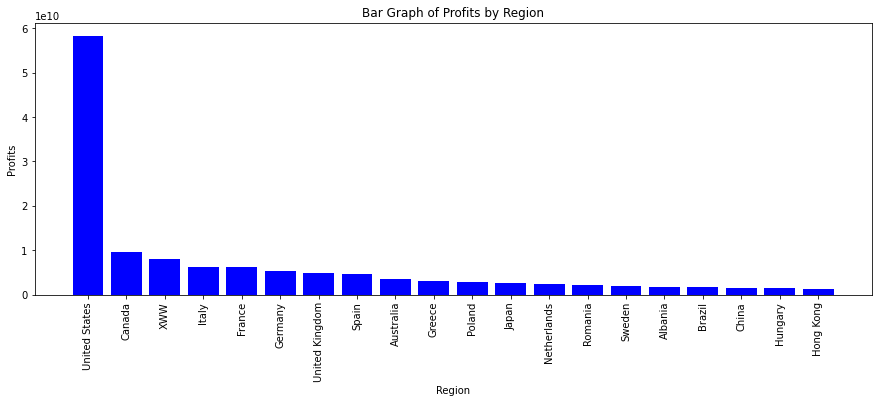

In [ ]:
#Getting the full names of each country in the region column
imdb_region_dict = {
    'US': 'United States', 'CA': 'Canada', 'GB': 'United Kingdom', 'AU': 'Australia', 'IN': 'India',
    'DE': 'Germany', 'FR': 'France', 'IT': 'Italy', 'ES': 'Spain', 'MX': 'Mexico', 'BR': 'Brazil',
    'JP': 'Japan', 'CN': 'China', 'KR': 'South Korea', 'RU': 'Russia', 'PL': 'Poland', 'ZA': 'South Africa',
    'AR': 'Argentina', 'NG': 'Nigeria', 'NL': 'Netherlands', 'SE': 'Sweden', 'DK': 'Denmark', 'NO': 'Norway',
    'FI': 'Finland', 'BE': 'Belgium', 'AT': 'Austria', 'CH': 'Switzerland', 'PT': 'Portugal', 'GR': 'Greece',
    'TR': 'Turkey', 'EG': 'Egypt', 'SG': 'Singapore', 'MY': 'Malaysia', 'ID': 'Indonesia', 'PH': 'Philippines',
    'TH': 'Thailand', 'VN': 'Vietnam', 'KW': 'Kuwait', 'SA': 'Saudi Arabia', 'AE': 'United Arab Emirates',
    'QA': 'Qatar', 'HK': 'Hong Kong', 'TW': 'Taiwan', 'IS': 'Iceland', 'LU': 'Luxembourg', 'IE': 'Ireland',
    'PL': 'Poland', 'HR': 'Croatia', 'RS': 'Serbia', 'UA': 'Ukraine', 'RO': 'Romania', 'BG': 'Bulgaria',
    'HR': 'Croatia', 'SK': 'Slovakia', 'SI': 'Slovenia', 'CZ': 'Czech Republic', 'HU': 'Hungary', 'EE': 'Estonia',
    'LV': 'Latvia', 'LT': 'Lithuania', 'UA': 'Ukraine', 'BY': 'Belarus', 'MD': 'Moldova', 'AM': 'Armenia',
    'GE': 'Georgia', 'AZ': 'Azerbaijan', 'KG': 'Kyrgyzstan', 'UZ': 'Uzbekistan', 'KZ': 'Kazakhstan', 'TJ': 'Tajikistan',
    'TM': 'Turkmenistan', 'MN': 'Mongolia', 'LA': 'Laos', 'KH': 'Cambodia', 'NP': 'Nepal', 'BT': 'Bhutan',
    'PK': 'Pakistan', 'AF': 'Afghanistan', 'LK': 'Sri Lanka', 'MM': 'Myanmar', 'BD': 'Bangladesh', 'KP': 'North Korea',
    'AL': 'Albania', 'JM': 'Jamaica', 'CO': 'Colombia', 'CM': 'Cameroon'
}

#converting the region column to strings
all_combined['region'] = all_combined['region'].astype(str)

#making a unique movies df
unique_movies = all_combined.drop_duplicates(subset='title')

#grouping by country and sorting for highest sum profits
reg_prof = unique_movies.groupby('region')['profits'].sum().sort_values(ascending=False).head(20)

#mapping each country abbreviation to the country's full name
reg_prof.index = reg_prof.index.map(lambda x: imdb_region_dict.get(x, str(x)))

#plotting a bar graph for the data
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(reg_prof.index, reg_prof.values, color='blue')
ax.set_title('Bar Graph of Profits by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Profits')
plt.xticks(rotation=90)
plt.show()

### Insights from the graph above


We can see that by far the highest profits were made in the United States. This is probably due to the fact that the datasets are imbalanced towards movies produced in America. We can see that the Canada, Italy, France, Germany, United Kindgom are following America, these are western countries where a large proportion of the population make movies. We can conclude that if we make movies in english we are likely to make money from western english speaking countries.

However it would be better to have a dataset with more movies in other languages.


### Next we will make a graph of Correlation Between Average Vote and Popularity


We will then make the each point correspond to the genre of the movie. The colors will help us see if the genre is connected to the average vote and popularity

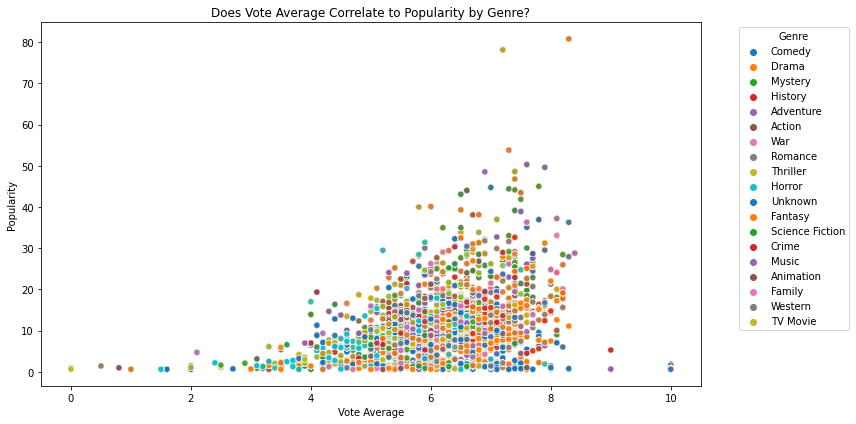

In [28]:
genre_dict = {
    28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy',
    80: 'Crime', 18: 'Drama', 10751: 'Family', 14: 'Fantasy',
    36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery',
    10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie',
    53: 'Thriller', 10752: 'War', 37: 'Western'
}

# Cleaning and preparing the genre names
all_combined['genre_ids'] = all_combined['genre_ids'].apply(
    lambda x: [int(i) for i in str(x).strip('[]').split(', ') if i.isdigit()] if isinstance(x, (list, str)) else []
)
all_combined['genre_names'] = all_combined['genre_ids'].apply(
    lambda ids: [genre_dict.get(genre_id, 'Unknown') for genre_id in ids]
)

# Explode genres for independent rows
df = all_combined.explode('genre_names').dropna(subset=['genre_names', 'popularity', 'vote_average'])

# Plot: vote_average vs popularity grouped by genres
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='vote_average', y='popularity', hue='genre_names', palette='tab10', alpha = 0.7)

plt.title('Does Vote Average Correlate to Popularity by Genre?')
plt.xlabel('Vote Average')
plt.ylabel('Popularity')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

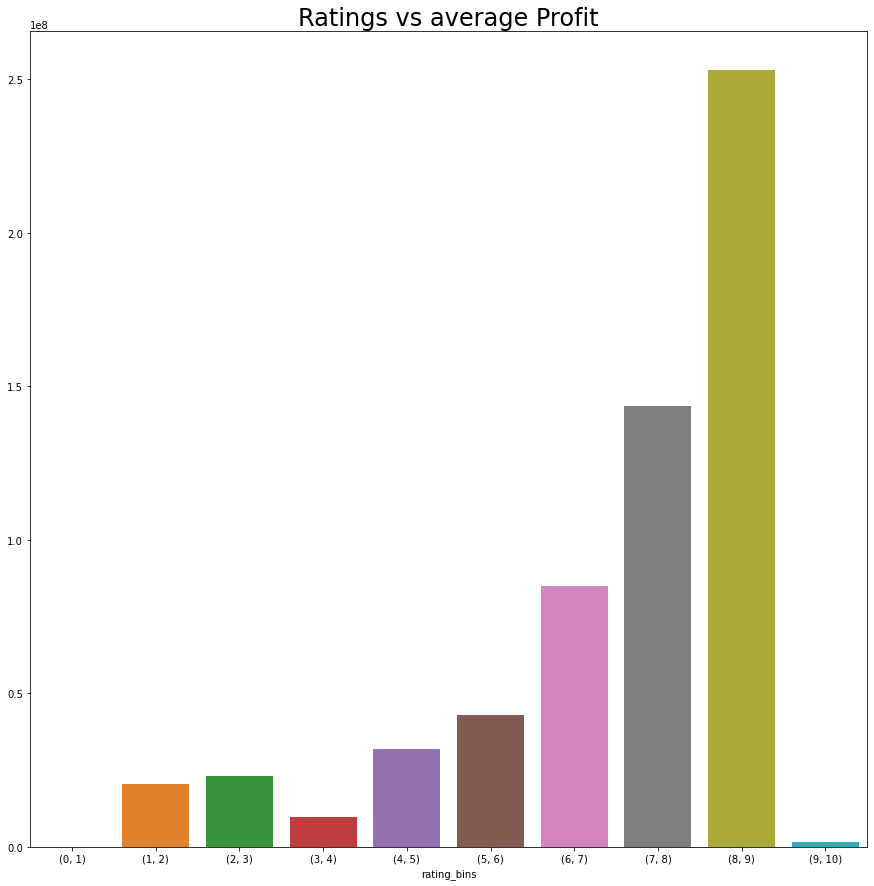

In [125]:
#group by averagerating vs profits per movie
#im gonna create bins for the ratings 1,2,3,4 to 10 
rating_bins = [1,2,3,4,5,6,7,8,9,10]
all_combined['rating_bins'] = pd.cut(all_combined['averagerating'],bins=[0,1,2,3,4,5,6,7,8,9,10])

#then I want to make sure the df is only showing unique movies
unique_movies = all_combined.drop_duplicates(subset='title')


#making a table with the index as the rating_bins and columns for the number of movies and the mean_profit
ratings_profits_mean = unique_movies.groupby('rating_bins').agg(num_movies=('movie_id','count')
                                                                    ,mean_profit=('profits','mean'),mean_popularity=('popularity','mean')
                                                                                                    ).sort_values('mean_profit',ascending=False)


#creating x_tick labels
rating_ranges=  [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]

#plotting the graph
fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=ratings_profits_mean,x=ratings_profits_mean.index,y=ratings_profits_mean['mean_profit'].values,)
ax.set_xticklabels(rating_ranges)
ax.set_title('Ratings vs average Profit',fontdict={'fontsize':24});



### Insights from the graph above:

The general pattern that we see is as the ratings increase the mean profits also increase.

From the cell below we can see that the reason why the 9-10 rating movies have a low profit is because there is only one movie that had this rating.
From the mean popularity column we can see that the 9-10 movie wasn't very popular. This could be due to the fact that the best movies aren't the most entertaining.
But we can see that the 8-9 movie ratings are the most popular. We must make a movie that has a balance between being technically good while remaining entertaining
to the average consumer.

In [123]:
ratings_profits_mean

,num_movies,mean_profit,mean_popularity
rating_bins,,,
"(8, 9]",46,2.529563e+08,17.486326
"(7, 8]",364,1.435457e+08,13.493940
"(6, 7]",694,8.514308e+07,11.455536
"(5, 6]",434,4.286585e+07,9.227673
"(4, 5]",166,3.199411e+07,7.056042
"(2, 3]",11,2.295958e+07,2.690455
"(1, 2]",2,2.055392e+07,6.653500
"(3, 4]",63,9.696038e+06,5.370143
"(9, 10]",1,1.495262e+06,5.577000


The graph below is a line graph that shows the same information as the one above.

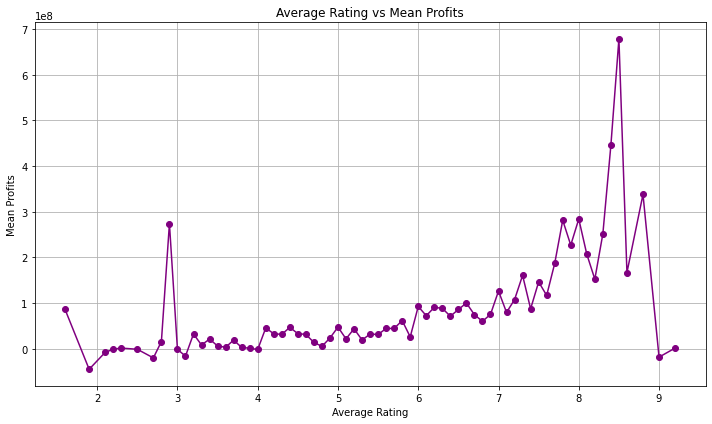

In [124]:
# Group by average_vote and compute mean profits
grouped = unique_movies.groupby('averagerating')['profits'].mean().reset_index()

# Convert to numpy arrays to avoid indexing issues (as a safeguard)
x = grouped['averagerating'].values
y = grouped['profits'].values

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='purple')
plt.title('Average Rating vs Mean Profits')
plt.xlabel('Average Rating')
plt.ylabel('Mean Profits')
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Top 20 Directors ranked by average profit')

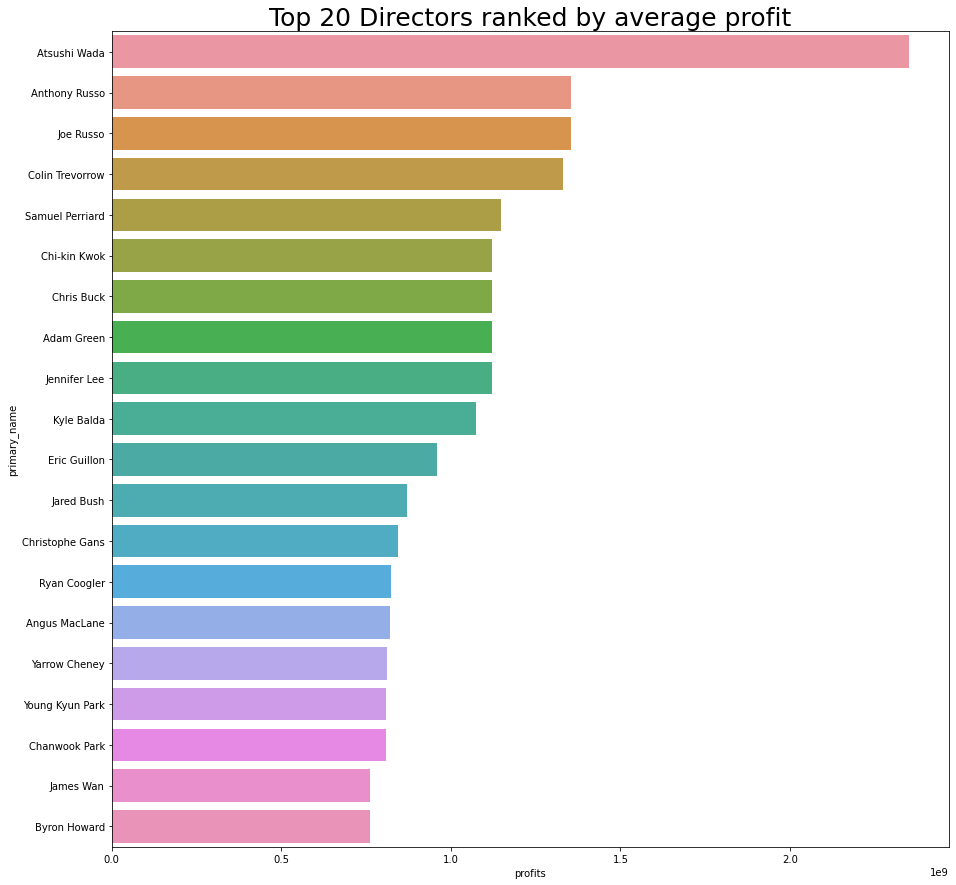

In [127]:
#average profits per director
directors_id_groupby = all_combined[all_combined['category'] == 'director'].groupby('primary_name').mean().sort_values('profits',ascending=False)
top_20_directors_by_profit = directors_id_groupby.head(20)
top_20_directors_by_profit

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_20_directors_by_profit,x='profits',y=top_20_directors_by_profit.index)
ax.set_title('Top 20 Directors ranked by average profit',fontdict={'fontsize':25})


Text(0.5, 1.0, 'Top 30 Actors ranked by average profit')

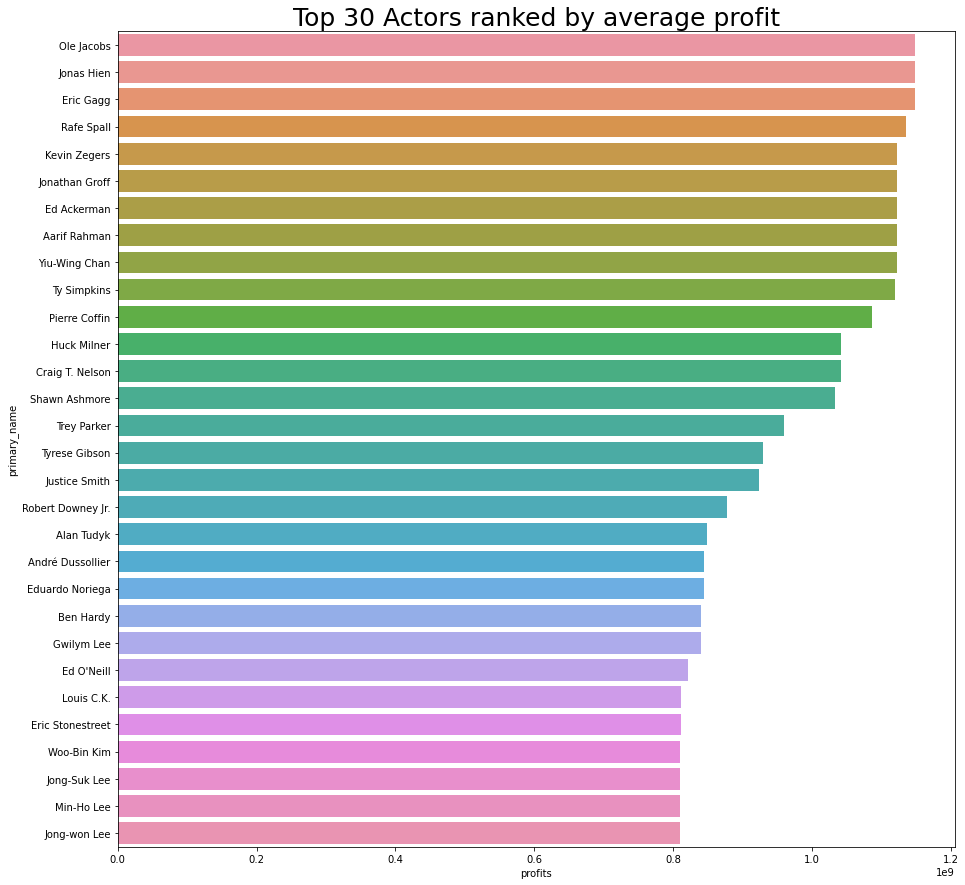

In [34]:
#average profits per director
directors_id_groupby = all_combined[all_combined['category'] == 'actor'].groupby('primary_name').mean().sort_values('profits',ascending=False)
top_20_directors_by_profit = directors_id_groupby.head(30)
top_20_directors_by_profit

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_20_directors_by_profit,x='profits',y=top_20_directors_by_profit.index)
ax.set_title('Top 30 Actors ranked by average profit',fontdict={'fontsize':25})

Text(0.5, 1.0, 'Top 10 Genres ranked by average profit')

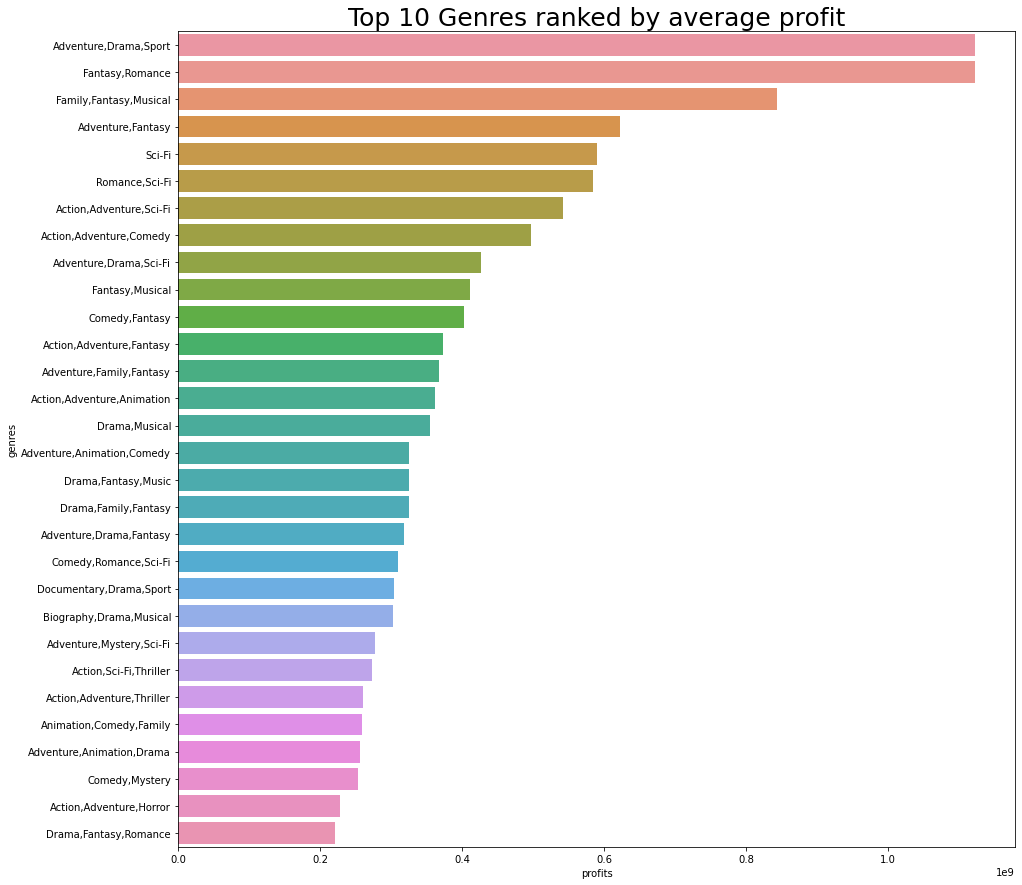

In [35]:
mean_genre_groupby = all_combined.groupby('genres').mean().sort_values('profits',ascending=False)
top_30_genres_average_profits = mean_genre_groupby.head(30)

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_30_genres_average_profits,x='profits',y=top_30_genres_average_profits.index)
ax.set_title('Top 10 Genres ranked by average profit',fontdict={'fontsize':25})


<AxesSubplot:xlabel='production_budget', ylabel='profits'>

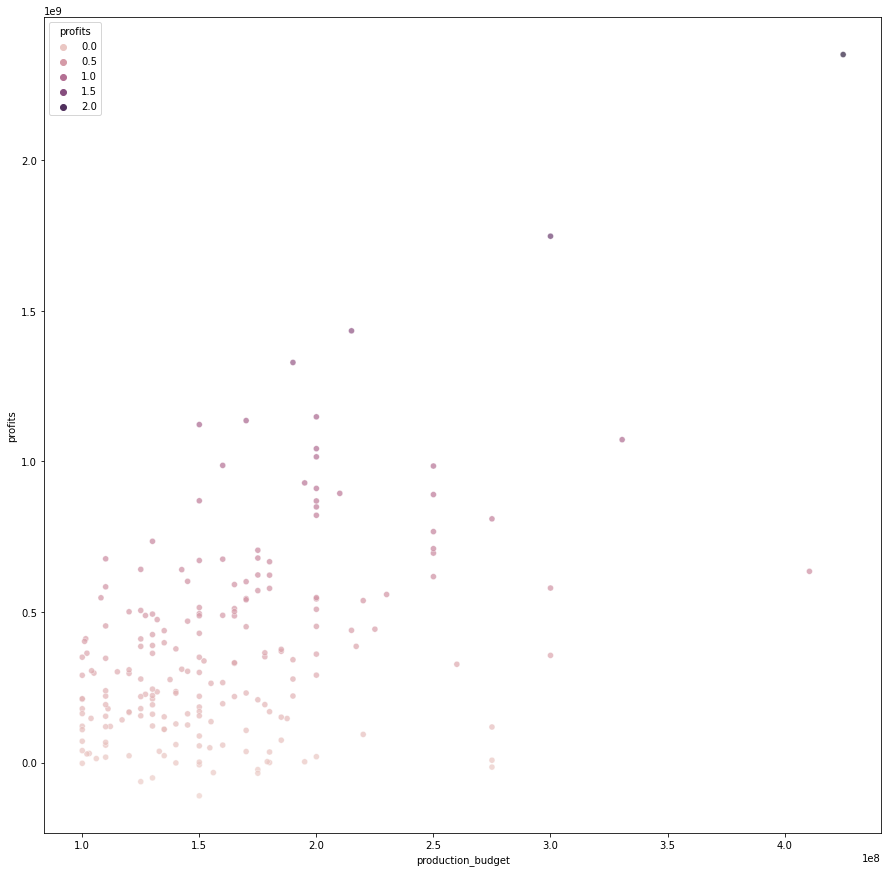

In [36]:
fig,ax = plt.subplots(figsize=(15,15))
movie_budgets_ranking  = all_combined.groupby('title').mean().sort_values('production_budget',ascending=False)
top_200_movie_budgets_ranking = movie_budgets_ranking.head(200)

sns.scatterplot(data=top_200_movie_budgets_ranking,x='production_budget',y='profits',alpha=0.7,hue='profits')


#### Add a visual showing animation vs real movies.

We will look at the genres column.
Any row that has the string animation will be counted as that
We will compare that to the rest of the dataset

Text(0.5, 1.0, 'Animated and Non-Animated vs Mean Profits')

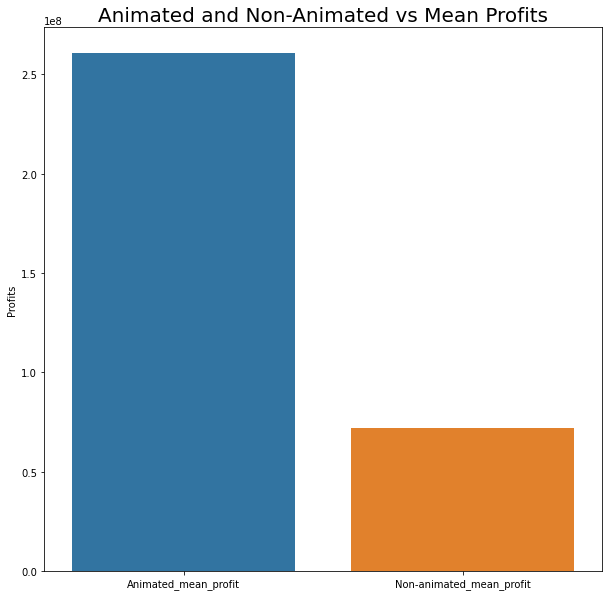

In [148]:
unique_movies  = all_combined.drop_duplicates(subset='title')

animation_movies = unique_movies[unique_movies['genres'].str.contains('animation',case=False) == True]
animation_movies_profits = animation_movies[['title','profits']]
animation_mean_profit = animation_movies_profits['profits'].mean()
# animation_movies['genres'].value_counts()
not_animated = unique_movies[unique_movies['genres'].str.contains('animation',case=False) == False]
not_animated_profits = not_animated[['title','profits']]
not_animated_mean_profit = not_animated_profits['profits'].mean()
# all_combined['genres'].str.contains('animation')

# df = pd.DataFrame(data= {'Animated_mean_profit':[animation_mean_profit],
#                    'Non-animated_mean_profit': [not_animated_mean_profit]}).transpose()

df = pd.DataFrame(data= {'Profits':[animation_mean_profit,not_animated_mean_profit],}
                  ,index=['Animated_mean_profit','Non-animated_mean_profit'])

# df

fig,ax = plt.subplots(figsize=(10,10))
sns.barplot(data=df,x=df.index,y=df['Profits'])
plt.title('Animated and Non-Animated vs Mean Profits',fontdict={'fontsize':20})


<AxesSubplot:xlabel='popularity', ylabel='mean_profit'>

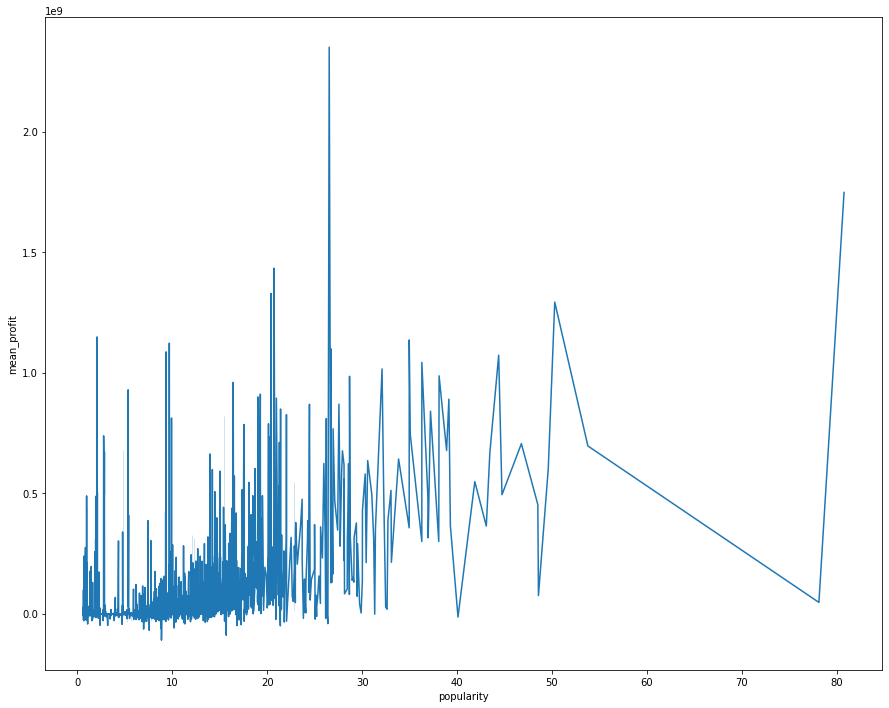

In [162]:
#popular movies vs Profits

unique_movies = all_combined.drop_duplicates(subset='title')

movies_ranked_profit = unique_movies.groupby('title').agg(mean_profit = ('profits','mean')
                                                          ,popularity=('popularity','mean')
                                                          ).sort_values('mean_profit',ascending=False)

fig,ax= plt.subplots(figsize=(15,12))
sns.lineplot(data=movies_ranked_profit,y='mean_profit',x='popularity')

The graph above ranked profit vs popularity of each movie

In [161]:
movies_ranked_profit.head(20)

,mean_profit,popularity
title,,
Avatar,2.351345e+09,26.526
Avengers: Infinity War,1.748134e+09,80.773
Jurassic World,1.433855e+09,20.709
Furious 7,1.328723e+09,20.396
The Avengers,1.292936e+09,50.289
Black Panther,1.148258e+09,2.058
Jurassic World: Fallen Kingdom,1.135773e+09,34.958
Frozen,1.122470e+09,9.678
Beauty and the Beast,1.099200e+09,26.701


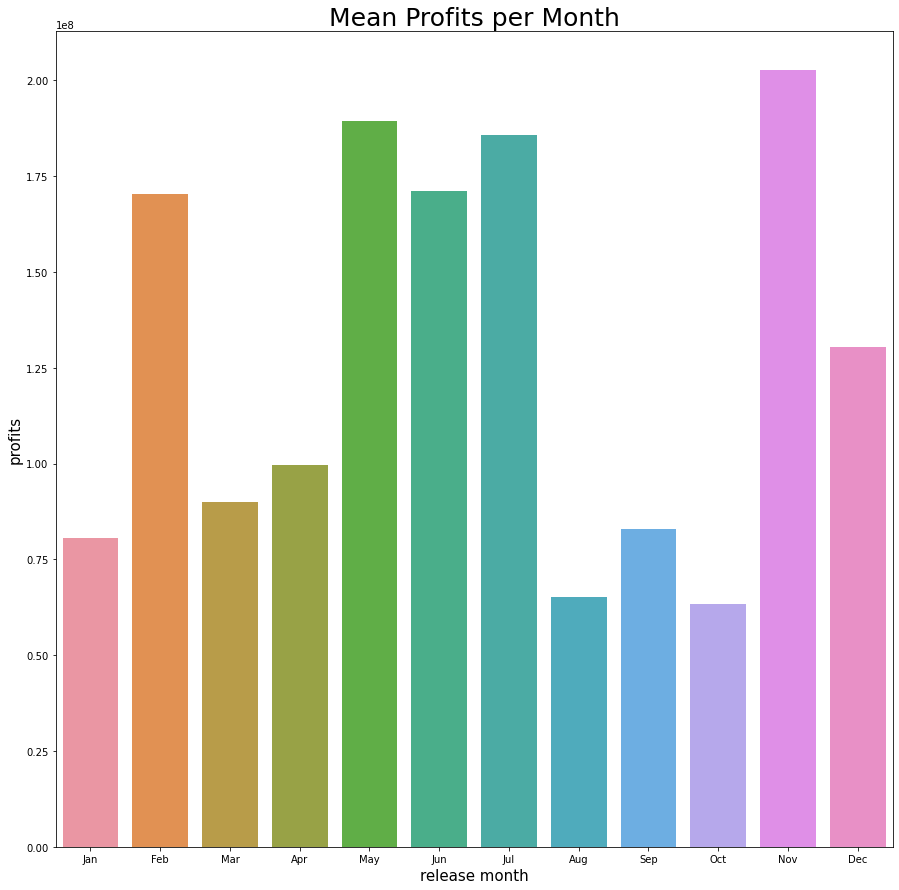

In [38]:
# Monthly Profit Trends (Line Plot)
fig,ax = plt.subplots(figsize=(15,15))
all_combined['release_month'] = pd.to_datetime(all_combined['release_date_x']).dt.month
monthly_profit = all_combined.groupby('release_month')['profits'].mean()
# monthly_profit
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

sns.barplot(x=monthly_profit.index, y=monthly_profit.values)
ax.set_xticklabels(months)
plt.title(label='Mean Profits per Month',fontdict={'fontsize':25})
plt.xlabel(fontdict={'fontsize':15},xlabel='release month')
plt.ylabel(fontdict={'fontsize':15},ylabel='profits');


<h2>Step 5. Hypothesis Testing<h2>

In [39]:
def cohen_d(a, b):
    n1, n2 = len(a), len(b)
    pooled_std = np.sqrt(((n1-1)*np.var(a, ddof=1) + (n2-1)*np.var(b, ddof=1)) / (n1 + n2 - 2))
    return (np.mean(a) - np.mean(b)) / pooled_std


<h5>Question 1: Do movies with top-rated directors (Group A) generate higher profits than those with lower-rated directors (Group B)?

Null Hypothesis: Movies with top-rated directors (Group A) generate equal profit compared to those with lower-rated directors (Group B)?

Alternative Hypothesis: Movies with top-rated directors (Group A) generate more profits compared to those with lower-rated directors (Group B)? </h5>

   #### Groups:

    #####   Group A: Movies directed by directors in the top 10% by averagerating or profits.

    #####    Group B: Movies directed by others.

    #### Metric: Compare mean profits or worldwide_gross.

    #### Method: Use a two-sample t-test to check if the difference is statistically significant.

In [40]:

directors_top_10 = all_combined[all_combined['category'] == 'director'].groupby('primary_name').mean().sort_values('averagerating',ascending=False)
top_100_directors_average_rating_profits = directors_top_10['profits'].head(100)
# mean_profits_top_50_directors = top_50_directors_average_rating_profits.mean()

not_top_100_directors_average_rating_profits = directors_top_10.tail(834)
random_sample_100_not_top_100 = not_top_100_directors_average_rating_profits['profits'].sample(n=50,random_state=6)


alpha = 0.05
t_statistic, p_value = stats.ttest_ind(top_100_directors_average_rating_profits,random_sample_100_not_top_100,equal_var=True)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05')
    print('Movies with more popular directors do not generate equal profits')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')

effect_size = cohen_d(top_100_directors_average_rating_profits,random_sample_100_not_top_100)
print('The effect size of the following was: ',effect_size)
print('A cohen d value of 0.44 indicates that the difference between having a top 100 director is noticable \n and is something the studio should look out for')


t-stat:  2.5637634165318914
p_value:  0.011351146206348809
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05
Movies with more popular directors do not generate equal profits
The effect size of the following was:  0.4440568496019606
A cohen d value of 0.44 indicates that the difference between having a top 100 director is noticable 
 and is something the studio should look out for


In [ ]:
#the popularity column is for movie popularity.
#change the hypothesis test to check for movie popularity

#organize actors by popularity
#null hypothesis: more popular movies dont make same profits
#alternate: more popular movies make more profits.
movies_ranked_popularity = all_combined.groupby('title').mean().sort_values('popularity',ascending=False)
top_200_popular_movies = movies_ranked_popularity['profits'].head(200)
not_top_200_movies = movies_ranked_popularity.tail(1410)
random_sample_200_movies_not_top_200 = not_top_200_movies['profits'].sample(n=200,random_state=42)

alpha = 0.05
t_statistic, p_value = stats.ttest_ind(top_200_popular_movies,random_sample_200_movies_not_top_200,equal_var=True)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.')
    print('More popular movies do not make the same profits as less popular movies')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')


effect_size = cohen_d(top_200_popular_movies,random_sample_200_movies_not_top_200)
print('The effect size of the following was: ',effect_size)
print('A cohen d value of 1.25 indicates that the difference between having a movie popularity is highly impactful when it comes to making profits ' \
'       \nthe studio should invest a large sum of the production budget into the advertising of the movie and the hiring of popular actors.')

t-stat:  12.256194189539704
p_value:  1.605553663337206e-29
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.
More popular movies do not make the same profits as less popular movies
The effect size of the following was:  1.2256194189539704
A cohen d value of 1.25 indicates that the difference between having a movie popularity is highly impactful when it comes to making profits        
the studio should invest a large sum of the production budget into the advertising of the movie and the hiring of popular actors.


In [42]:
# all_combined[['title','runtime_minutes']].groupby('title').mean().sort_values('runtime_minutes',ascending=True).head(50)

#Question 3: Movies with higher ratings make more profit?

#Null: Movies with higher ratings don't make higher profits?
#alternate: Movies with higher ratings make more profits?


highest_rated_movies = all_combined.groupby('title').mean().sort_values('averagerating',ascending=False)
top_100_rated_movies_profits = highest_rated_movies['profits'].head(100)

not_top_100_movies = highest_rated_movies.tail(894)
sample_not_top_100_movies_profits = not_top_100_movies['profits'].sample(n=100,random_state=42)

alpha = 0.05
t_statistic, p_value = stats.ttest_ind(top_100_rated_movies_profits,sample_not_top_100_movies_profits,equal_var=True)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.')
    print('More highest-rated movies do not make the same profits as lower-rated movies')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')


effect_size = cohen_d(top_100_rated_movies_profits,sample_not_top_100_movies_profits)
print('The effect size of the following was: ',effect_size)




t-stat:  5.198120400069214
p_value:  4.994850179731832e-07
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.
More highest-rated movies do not make the same profits as lower-rated movies
The effect size of the following was:  0.7351252368626141


In [43]:
#Hypothesis number 4
#Alternative hypothesis: The sci-fi genre makes more profits than any other genre?
#Null Hypothesis: The sci-fi genre do not make more profit than other genres?
df_clean =all_combined.copy() 

# Create sci-fi flag (handling multi-genre entries)
df_clean['is_sci_fi'] = df_clean['genres'].str.contains('Sci-Fi', case=False, na=False)

# Split into groups
sci_fi_profits = df_clean[df_clean['is_sci_fi']]['profits']
non_sci_fi_profits = df_clean[~df_clean['is_sci_fi']]['profits']


sample_sci_fi = sci_fi_profits.sample(n=3000,random_state=42)
sample_not_sci_fi = non_sci_fi_profits.sample(n=3000,random_state=42)

t_statistic, p_value = stats.ttest_ind(sci_fi_profits, non_sci_fi_profits, equal_var=True)



alpha = 0.05
t_statistic, p_value = stats.ttest_ind(sample_sci_fi,sample_not_sci_fi)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.')
    print('More highest-rated movies do not make the same profits as lower-rated movies')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')


effect_size = cohen_d(sample_sci_fi,sample_not_sci_fi)
print('The effect size of the following was: ',effect_size)



t-stat:  21.165893223018443
p_value:  5.911952845658302e-96
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.
More highest-rated movies do not make the same profits as lower-rated movies
The effect size of the following was:  0.5465010130690323
